In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount('/content/drive')

Mounted at /content/gdrive
Mounted at /content/drive


In [3]:
!pwd
!mkdir datasets
%cd /content/drive/MyDrive/ml_hw2
!ls
!unzip -uq ETT_v3.zip -d "/content/datasets"

!mkdir -p /content/datasets/ETT_v3/ETT_v3/Fold1/predict /content/datasets/ETT_v3/ETT_v3/Fold1/aug
!mkdir -p /content/datasets/ETT_v3/ETT_v3/Fold2/predict /content/datasets/ETT_v3/ETT_v3/Fold2/aug
!mkdir -p /content/datasets/ETT_v3/ETT_v3/Fold3/predict /content/datasets/ETT_v3/ETT_v3/Fold3/aug
!mkdir -p /content/datasets/ETT_v3/ETT_v3/Fold4/predict /content/datasets/ETT_v3/ETT_v3/Fold4/aug
!mkdir -p /content/datasets/ETT_v3/ETT_v3/Fold5/predict /content/datasets/ETT_v3/ETT_v3/Fold5/aug


# Colab防斷連
# function ConnectButton(){
# console.log("Connect pushed");
# document.querySelector("colab-connect-button").shadowRoot.querySelector("#connect").click();
# }
# setInterval(ConnectButton,60000);

/content
/content/drive/MyDrive/ml_hw2
ETT_v3.zip  model_ck


In [4]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans
import cv2
import matplotlib.pyplot as plt

In [ ]:
# def crop_and_resize(input_image):

#   # print(input_image.shape)
#   y, x = input_image.shape[0], input_image.shape[1]

#   startx = x // 2 - ((x // 2) // 2)
#   starty = 0

#   input_image = input_image[starty: starty + y, startx: startx + x]

#   input_image = cv2.resize(input_image, (256, 256))
#   input_image = np.expand_dims(input_image, axis=-1)

#   # print(input_image.shape)

#   return input_image

In [5]:
def crop_and_resize(input_image):

  # print(input_image.shape)
  y, x = input_image.shape[0], input_image.shape[1]

  startx = x // 2 - (1280 // 2)
  starty = 0

  input_image = input_image[starty: starty + 2560, startx: startx + 2560]

  input_image = cv2.resize(input_image, (256, 256))
  input_image = np.expand_dims(input_image, axis=-1)

  # print(input_image.shape)

  return input_image

In [6]:
def adjustData(img, mask, flag_multi_class, num_class):
    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img, mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 23):

    image_datagen = ImageDataGenerator(**aug_dict, preprocessing_function=crop_and_resize)
    mask_datagen = ImageDataGenerator(**aug_dict, preprocessing_function=crop_and_resize)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        # target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        # target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        # print(img, mask)
        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        yield (img,mask)


# def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
#     for i in range(num_image):
#         img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
#         img = img / 255
#         img = trans.resize(img,target_size)
#         img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
#         img = np.reshape(img,(1,)+img.shape)
#         yield img


# def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
#     image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
#     image_arr = []
#     mask_arr = []
#     for index,item in enumerate(image_name_arr):
#         img = io.imread(item,as_gray = image_as_gray)
#         img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
#         mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
#         mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
#         img,mask = adjustData(img,mask,flag_multi_class,num_class)
#         image_arr.append(img)
#         mask_arr.append(mask)
#     image_arr = np.array(image_arr)
#     mask_arr = np.array(mask_arr)
#     return image_arr,mask_arr


# def labelVisualize(num_class,color_dict,img):
#     img = img[:,:,0] if len(img.shape) == 3 else img
#     img_out = np.zeros(img.shape + (3,))
#     for i in range(num_class):
#         img_out[img == i,:] = color_dict[i]
#     return img_out / 255



# def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
#     for i,item in enumerate(npyfile):
#         img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
#         io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [7]:
fold1_path = "/content/datasets/ETT_v3/ETT_v3/Fold1"
fold2_path = "/content/datasets/ETT_v3/ETT_v3/Fold2"
fold3_path = "/content/datasets/ETT_v3/ETT_v3/Fold3"
fold4_path = "/content/datasets/ETT_v3/ETT_v3/Fold4"
fold5_path = "/content/datasets/ETT_v3/ETT_v3/Fold5"

test = "/test"
testannot = "/testannot"
train = "/train"
trainannot = "/trainannot"
val = "/val"
valannot = "/valannot"

In [8]:
gen_args = dict(rotation_range=15,
                width_shift_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest')

In [9]:
myGenerator = trainGenerator(2, fold1_path, "train", "trainannot", gen_args, save_to_dir = fold1_path + "/aug")

In [10]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None, input_size = (256,256,1), opt = "Adam"):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if (opt == "Adam"):
      print("Addam")
      model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    elif (opt == "rmsprop"):
      print("rmsprop")
      model.compile(optimizer = RMSprop(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    # model.summary()

    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model


In [68]:
unet_model_adam = unet(opt = "Adam")
unet_model_rmsprop = unet(opt = "rmsprop")

Addam
rmsprop


In [36]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 100) / (K.sum(y_true_f) + K.sum(y_pred_f) + 100)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_save_path1="/content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unet_checkpoint.model.keras"
checkpoint_save_path2="/content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unet_checkpoint.model.keras"


earlystop = EarlyStopping(monitor='loss', patience=5,
                          mode='min', verbose=1)

checkpoint_adam = ModelCheckpoint(checkpoint_save_path1,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

checkpoint_rmsprop = ModelCheckpoint(checkpoint_save_path2,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

reduce_lr=ReduceLROnPlateau(monitor='accuracy',
                             patience=3,
                             verbose=1,
                             factor=0.1,
                             min_lr=0.00001
                             )

In [12]:
def read_imgs_and_prepare(images_path, masks_path, image_as_gray = True, mask_as_gray = True, target_size=(256, 256)):
    image_names = os.listdir(images_path)
    mask_names = os.listdir(masks_path)

    image_names.sort()
    mask_names.sort()

    images = []
    masks = []

    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(images_path, img_name)
        mask_path = os.path.join(masks_path, mask_name)

        img = io.imread(img_path, as_gray=image_as_gray)
        mask = io.imread(mask_path, as_gray=mask_as_gray)

        y, x = img.shape[0], img.shape[1]

        # print(img.shape)
        startx = x // 2 - ((1280) // 2)
        starty = 0
        img = img[starty: starty + 2560, startx: startx + 2560]

        y, x = mask.shape[0], mask.shape[1]
        startx = x // 2 - ((1280) // 2)
        starty = 0
        mask = mask[starty: starty + 2560, startx: startx + 2560]

        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    images = np.asarray(images, np.float32)
    masks = np.asarray(masks, np.float32)

    for img in images:
      if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
    for mask in masks:
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

    return images, masks

In [13]:
val_images1, val_masks1 = read_imgs_and_prepare(fold1_path+val, fold1_path+valannot)

shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


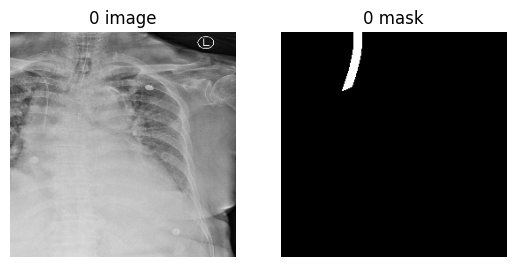

In [14]:
if val_images1.any() and val_masks1.any():
    # 檢查圖

    plt.figure()
    print("shape of 1st image", val_images1[2].shape)
    print("shape of 1st mask:", val_masks1[2].shape)

    plt.subplot(1, 2, 1)
    plt.imshow(val_images1[2], cmap='gray')
    plt.title(f"{0} image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(val_masks1[2], cmap='gray')
    plt.title(f"{0} mask")
    plt.axis('off')
    plt.show()

In [15]:
print(val_images1.shape[0])

47


In [ ]:
# 用imagegenerator沒辦法上colab的tpu= =

# import tensorflow as tf

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# with tpu_strategy.scope():
#   unet_model_adam = unet(opt = "Adam")
#   unet_model_rmsprop = unet(opt = "rmsprop")

In [78]:
unet_model_adam.fit(myGenerator,
              steps_per_epoch=287/2,
              epochs= 10,
              validation_data=(val_images1, val_masks1),
              validation_steps= (val_images1.shape[0] // 2),
              callbacks=[checkpoint_adam, earlystop, reduce_lr])

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9927


Epoch 1: accuracy improved from 0.99050 to 0.99268, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unet_checkpoint.model.keras
143/143 [==============================] - 34s 236ms/step - loss: 0.0196 - accuracy: 0.9927 - val_loss: 7.8350 - val_accuracy: 0.9877 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9925
Epoch 2: accuracy did not improve from 0.99268
143/143 [==============================] - 28s 193ms/step - loss: 0.0198 - accuracy: 0.9925 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9932
Epoch 3: accuracy improved from 0.99268 to 0.99319, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unet_checkpoint.model.keras
143/143 [==============================] - 30s 207ms/step - loss: 0.0179 - accuracy: 0.9932 - lr: 1.0000e-04
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9935
Epoch 4: 

In [75]:
unet_model_rmsprop.fit(myGenerator,
               steps_per_epoch=287/2,
               epochs= 10,
               validation_data=(val_images1, val_masks1),
               validation_steps= (val_images1.shape[0] // 2),
               callbacks=[checkpoint_rmsprop, earlystop, reduce_lr])

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9904


Epoch 1: accuracy improved from 0.98932 to 0.99035, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 32s 220ms/step - loss: 0.0275 - accuracy: 0.9904 - val_loss: 5.1273 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9909
Epoch 2: accuracy improved from 0.99035 to 0.99090, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 29s 204ms/step - loss: 0.0249 - accuracy: 0.9909 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9915
Epoch 3: accuracy improved from 0.99090 to 0.99146, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 29s 201ms/step - loss: 0.0224 - accuracy: 0.9915 - lr: 1.0000e-04


image_15_6930453
_15_6930453
mask_15_6930453


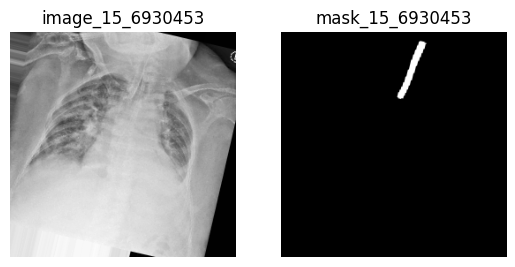

In [18]:
import re
draw_path = "/content/datasets/ETT_v3/ETT_v3/Fold1/aug"

files = os.listdir(draw_path)

for filename in files:
    if filename.startswith("image"):
        image_path = os.path.join(draw_path, filename)
        image_filename = filename.replace(".png", "")
        image_filename = image_filename.replace("mask", "")
        break

# image_num = str(re.search(r"_(\d+)_", image_filename).group(1))
print(image_filename)

mask_filaname = image_filename.replace("image", "")
print(mask_filaname)
mask_filaname = "mask" + mask_filaname
print(mask_filaname)

for filename in files:
    if filename.startswith(mask_filaname):
        mask_path = os.path.join(draw_path, filename)
        mask_filename = filename.replace(".png", "")
        break

image = plt.imread(image_path)
mask = plt.imread(mask_path)

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"{image_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(f"{mask_filename}")
plt.axis('off')

plt.show()

In [19]:
test_images1, test_masks1 = read_imgs_and_prepare(fold1_path+test, fold1_path+testannot)

shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


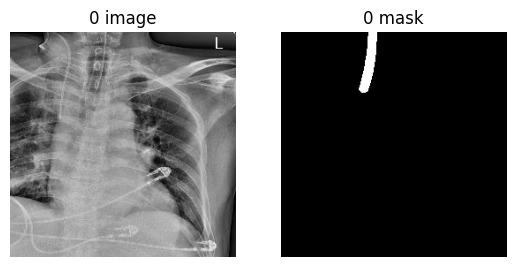

In [20]:
if test_images1.any() and test_masks1.any():
    # 檢查圖

    plt.figure()
    print("shape of 1st image", test_images1[0].shape)
    print("shape of 1st mask:", test_masks1[0].shape)

    plt.subplot(1, 2, 1)
    plt.imshow(test_images1[0], cmap='gray')
    plt.title(f"{0} image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_masks1[0], cmap='gray')
    plt.title(f"{0} mask")
    plt.axis('off')
    plt.show()

In [21]:
unet_model_adam.evaluate(test_images1, test_masks1, verbose=1, batch_size=2)

24/24 [==============================] - 1s 53ms/step - loss: 9.4262 - accuracy: 0.9895


[9.426207542419434, 0.989541232585907]

In [22]:
unet_model_rmsprop.evaluate(test_images1, test_masks1, verbose=1, batch_size=2)

24/24 [==============================] - 1s 50ms/step - loss: 1.0854 - accuracy: 0.9883


[1.0854140520095825, 0.9883130788803101]

In [81]:
results_f1_adam = unet_model_adam.predict(test_images1, 32, verbose=1)
results_f1_rmsprop = unet_model_rmsprop.predict(test_images1, 32, verbose=1)

# saveResult("/content/datasets/ETT_v3/ETT_v3/Fold1/predict",results)

2/2 [==============================] - 1s 552ms/step


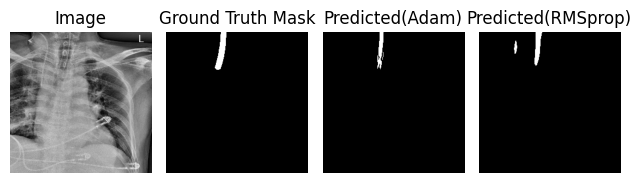

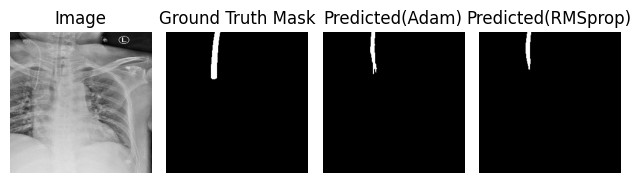

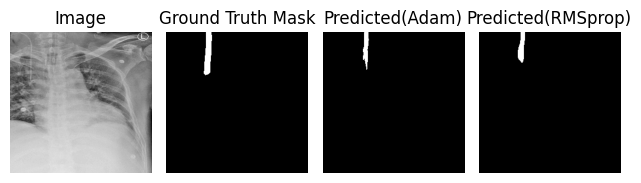

In [82]:
for index in range(3):

  fig = plt.figure()
  plt.subplot(1, 4, 1)
  plt.imshow(test_images1[index], cmap='gray')
  plt.axis('off')
  plt.title('Image')

  plt.subplot(1, 4, 2)
  plt.imshow(test_masks1[index], cmap='gray')
  plt.title("Ground Truth Mask")
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.imshow(results_f1_adam[index], cmap='gray')
  plt.axis('off')
  plt.title("Predicted(Adam)")

  plt.subplot(1, 4, 4)
  plt.imshow(results_f1_rmsprop[index], cmap='gray')
  plt.axis('off')
  plt.title("Predicted(RMSprop)")

  fig.tight_layout()

  plt.show()

In [84]:
from google.colab.patches import cv2_imshow

In [13]:
#還原圖片大小
def restore_size(img):
  resized_img = cv2.resize(img, (2560, 2560))
  return resized_img

# 找mask的端點(找出要算的Yi跟Gi)
def find_contour(binary_img, img_copy):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        bottom_point = tuple(max_contour[max_contour[:,:,1].argmax()][0])

        # print(bottom_point)
        # cv2.drawContours(img_copy, contours, -1, (255, 0, 0), 10)
        # cv2_imshow(img_copy)

        return bottom_point
    else:
        # print("No contour found.")
        return (0, 0)  # 返回一個空的底部點


def iou_score(y_true, y_pred):
  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  iou = np.sum(intersection) / np.sum(union)
  return iou

def mean_cm_error(y_true, y_pred):

  bi_img_true = cv2.convertScaleAbs(y_true)
  true_copy = y_true.copy()
  point_true = find_contour(bi_img_true, true_copy)

  bi_img_pred = cv2.convertScaleAbs(y_pred)
  pred_copy = y_pred.copy()
  point_pred = find_contour(bi_img_pred, pred_copy)

  # errors = np.abs(y_true - y_pred)
  errors = np.abs(point_true[1] - point_pred[1]) # 算誤差
  mean_error_cm = np.mean(errors) / (72/10)  # 像素轉換公分(圖片一開始有被縮小10倍, 所以除10)

  # acc_half_cm = np.mean(np.where(mean_error_cm <= 0.5, 1, 0)) * 100  # 計算誤差在 0.5 公分內準確率
  # acc_one_cm = np.mean(np.where(mean_error_cm <= 1, 1, 0)) * 100  # 計算誤差在 1 公分內準確率

  return mean_error_cm

def acc_error_in_half(y_true, y_pred):
  mean_error_cm = mean_cm_error(y_true, y_pred)
  acc_half_cm = np.mean(np.where(mean_error_cm <= 0.5, 1, 0)) * 100  # 計算誤差在 0.5 公分內準確率
  # print("half_cm:"+ str(acc_half_cm))
  return acc_half_cm

def acc_error_in_one(y_true, y_pred):
  mean_error_cm = mean_cm_error(y_true, y_pred)
  acc_one_cm = np.mean(np.where(mean_error_cm <= 1, 1, 0)) * 100  # 計算誤差在 1 公分內準確率
  return acc_one_cm

In [15]:
each_folds_perform_adam = []
each_folds_perform_rmsprop = []

In [14]:
def get_perform(train_results, test_results, opt, fold, train_real_masks, test_real_masks):
  train_iou_scores = []
  train_mecs = []
  train_error_halfs = []
  train_error_ones = []

  test_iou_scores = []
  test_mecs = []
  test_error_halfs = []
  test_error_ones = []

  for i in range(len(train_real_masks)):
    train_iou = iou_score(train_real_masks[i], train_results[i])
    train_mec = mean_cm_error(train_real_masks[i], train_results[i])
    train_half = acc_error_in_half(train_real_masks[i], train_results[i])
    train_one = acc_error_in_one(train_real_masks[i], train_results[i])
    train_iou_scores.append(train_iou)
    train_mecs.append(train_mec)
    train_error_halfs.append(train_half)
    train_error_ones.append(train_one)

  train_mean_iou = np.mean(train_iou_scores)
  train_mean_mec = np.mean(train_mecs)
  train_mean_error_half = np.mean(train_error_halfs)
  train_mean_error_one = np.mean(train_error_ones)

  print("--train--")
  print("Mean IOU:", train_mean_iou)
  print("Mean mec:", train_mean_mec)
  print("Mean error_half:", train_mean_error_half)
  print("Mean error_one:", train_mean_error_one)

  for i in range(len(test_real_masks)):
    test_iou = iou_score(test_real_masks[i], test_results[i])
    test_mec = mean_cm_error(test_real_masks[i], test_results[i])
    test_half = acc_error_in_half(test_real_masks[i], test_results[i])
    test_one = acc_error_in_one(test_real_masks[i], test_results[i])
    test_iou_scores.append(test_iou)
    test_mecs.append(test_mec)
    test_error_halfs.append(test_half)
    test_error_ones.append(test_one)

  test_mean_iou = np.mean(test_iou_scores)
  test_mean_mec = np.mean(test_mecs)
  test_mean_error_half = np.mean(test_error_halfs)
  test_mean_error_one = np.mean(test_error_ones)

  print("--test--")
  print("Mean IOU:", test_mean_iou)
  print("Mean mec:", test_mean_mec)
  print("Mean error_half:", test_mean_error_half)
  print("Mean error_one:", test_mean_error_one)

  return [fold, opt, train_mean_iou, train_mean_mec, train_mean_error_half, train_mean_error_one, test_mean_iou, test_mean_mec, test_mean_error_half, test_mean_error_one]

In [ ]:
each_folds_perform_adam.append(get_perform(results_f1_adam, "adam", "Fold1", test_masks1))
each_folds_perform_rmsprop.append(get_perform(results_f1_rmsprop, "rmsprop", "Fold1", test_masks1))

print(each_folds_perform_adam)
print(each_folds_perform_rmsprop)

Mean IOU: 0.1838146750538098
Mean mec: 1.7257683215130024
Mean error_half: 25.53191489361702
Mean error_one: 57.4468085106383
Mean IOU: 0.23720469891771515
Mean mec: 1.660756501182033
Mean error_half: 38.297872340425535
Mean error_one: 53.191489361702125
[['Fold1', 'adam', 0.1838146750538098, 1.7257683215130024, 25.53191489361702, 57.4468085106383]]
[['Fold1', 'rmsprop', 0.23720469891771515, 1.660756501182033, 38.297872340425535, 53.191489361702125]]


In [16]:
import pandas as pd

columns = ["Fold", "optimizer", "train_Mean IOU", "train_Mean mec", "train_Mean error_half", "train_Mean error_one", "test_Mean IOU", "test_Mean mec", "test_Mean error_half", "test_Mean error_one"]

In [ ]:
df1 = pd.DataFrame(each_folds_perform_adam, columns=columns)
df2 = pd.DataFrame(each_folds_perform_rmsprop, columns=columns)

result_df = pd.concat([df1, df2], ignore_index=True)

path = '/content/drive/MyDrive/output.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  result_df.to_csv(f)

# **Fold 2 ~ Fold 5**

In [17]:
fold_pathes = [fold1_path, fold2_path, fold3_path, fold4_path, fold5_path]

1
/content/datasets/ETT_v3/ETT_v3/Fold1
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


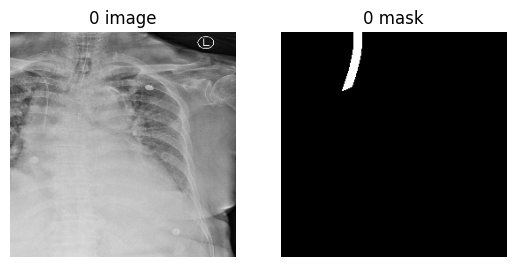

Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9942


Epoch 1: accuracy improved from -inf to 0.99421, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unet_checkpoint.model.keras
143/143 [==============================] - 32s 224ms/step - loss: 0.0146 - accuracy: 0.9942 - val_loss: 4.3431 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9945
Epoch 2: accuracy improved from 0.99421 to 0.99452, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unet_checkpoint.model.keras
143/143 [==============================] - 31s 213ms/step - loss: 0.0137 - accuracy: 0.9945 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9948
Epoch 3: accuracy improved from 0.99452 to 0.99481, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unet_checkpoint.model.keras
143/143 [==============================] - 31s 215ms/step - loss: 0.0135 - accuracy: 0.9948 - lr: 1.0000e-04
Epoch 4/10
1

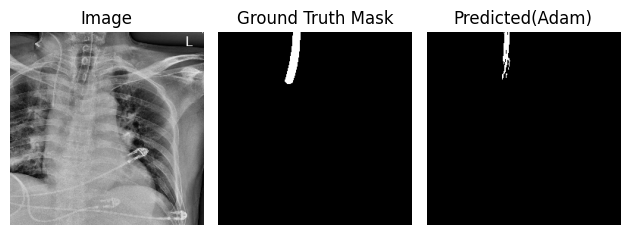

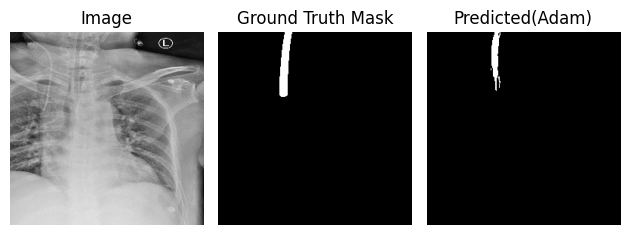

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9935


Epoch 1: accuracy improved from -inf to 0.99348, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 31s 219ms/step - loss: 0.0162 - accuracy: 0.9935 - val_loss: 4.7842 - val_accuracy: 0.9904 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9936
Epoch 2: accuracy improved from 0.99348 to 0.99360, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 29s 205ms/step - loss: 0.0166 - accuracy: 0.9936 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9934
Epoch 3: accuracy did not improve from 0.99360
143/143 [==============================] - 27s 192ms/step - loss: 0.0166 - accuracy: 0.9934 - lr: 1.0000e-04
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9937
Epoch 

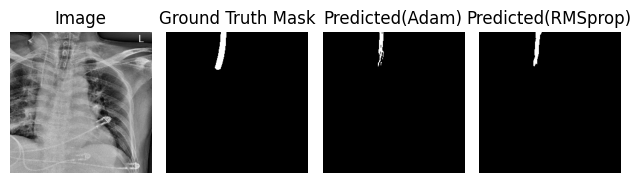

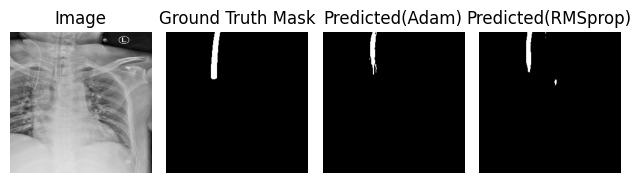

2
/content/datasets/ETT_v3/ETT_v3/Fold2
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


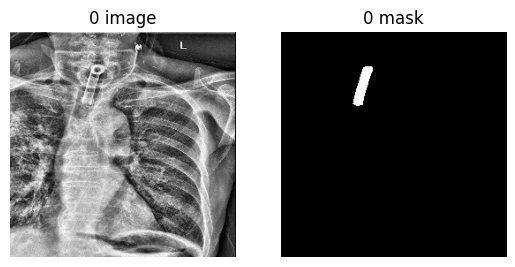

Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9957


Epoch 1: accuracy improved from -inf to 0.99570, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_adam_unet_checkpoint.model.keras
143/143 [==============================] - 32s 223ms/step - loss: 0.0107 - accuracy: 0.9957 - val_loss: 6.6330 - val_accuracy: 0.9918 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9958
Epoch 2: accuracy improved from 0.99570 to 0.99575, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_adam_unet_checkpoint.model.keras
143/143 [==============================] - 30s 210ms/step - loss: 0.0105 - accuracy: 0.9958 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9958
Epoch 3: accuracy improved from 0.99575 to 0.99585, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_adam_unet_checkpoint.model.keras
143/143 [==============================] - 30s 207ms/step - loss: 0.0104 - accuracy: 0.9958 - lr: 1.0000e-05
Epoch 4/10
1

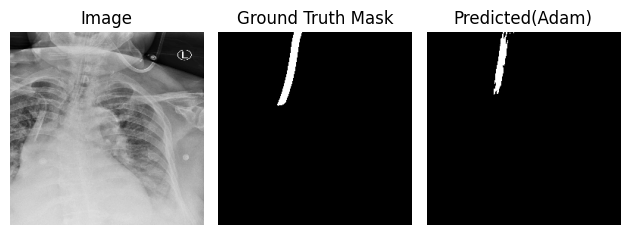

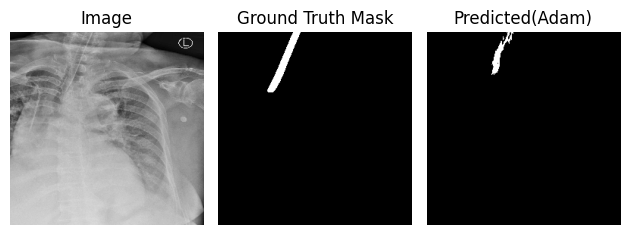

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9944


Epoch 1: accuracy improved from -inf to 0.99438, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 32s 225ms/step - loss: 0.0136 - accuracy: 0.9944 - val_loss: 2.2452 - val_accuracy: 0.9920 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9945
Epoch 2: accuracy improved from 0.99438 to 0.99452, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 29s 204ms/step - loss: 0.0139 - accuracy: 0.9945 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9943
Epoch 3: accuracy did not improve from 0.99452
143/143 [==============================] - 28s 194ms/step - loss: 0.0142 - accuracy: 0.9943 - lr: 1.0000e-04
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9946
Epoch 

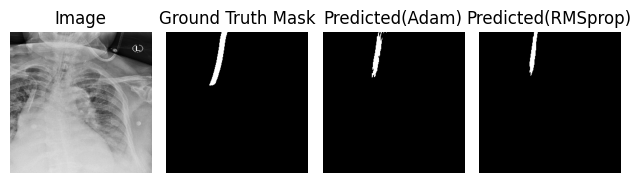

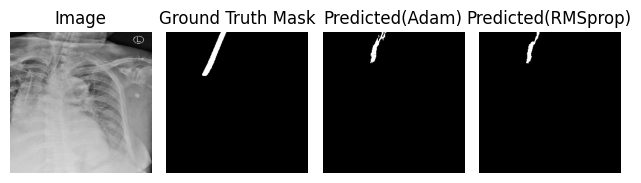

3
/content/datasets/ETT_v3/ETT_v3/Fold3
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


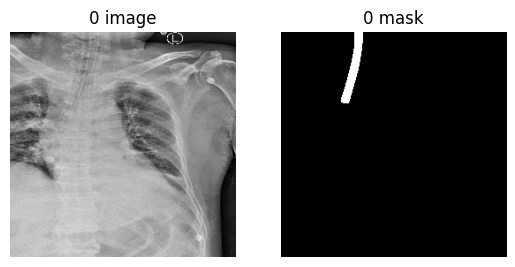

Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9960


Epoch 1: accuracy improved from -inf to 0.99597, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_adam_unet_checkpoint.model.keras
143/143 [==============================] - 32s 226ms/step - loss: 0.0100 - accuracy: 0.9960 - val_loss: 5.1025 - val_accuracy: 0.9913 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9961
Epoch 2: accuracy improved from 0.99597 to 0.99610, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_adam_unet_checkpoint.model.keras
143/143 [==============================] - 31s 214ms/step - loss: 0.0096 - accuracy: 0.9961 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9961
Epoch 3: accuracy improved from 0.99610 to 0.99614, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_adam_unet_checkpoint.model.keras
143/143 [==============================] - 30s 210ms/step - loss: 0.0097 - accuracy: 0.9961 - lr: 1.0000e-05
Epoch 4/10
1

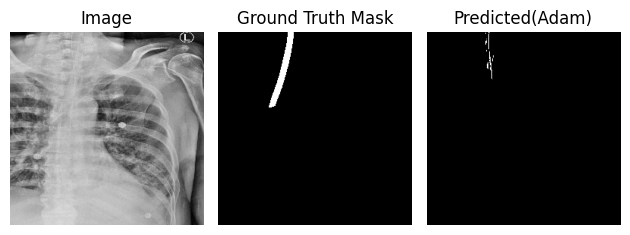

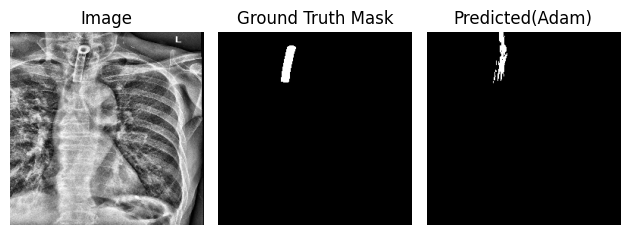

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9957


Epoch 1: accuracy improved from -inf to 0.99574, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 33s 227ms/step - loss: 0.0105 - accuracy: 0.9957 - val_loss: 3.4478 - val_accuracy: 0.9920 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9956
Epoch 2: accuracy did not improve from 0.99574
143/143 [==============================] - 28s 195ms/step - loss: 0.0110 - accuracy: 0.9956 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9957
Epoch 3: accuracy did not improve from 0.99574
143/143 [==============================] - 28s 192ms/step - loss: 0.0105 - accuracy: 0.9957 - lr: 1.0000e-05
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9956
Epoch 4: accuracy did not improve from 0.99574
143/143 [==============================] - 28s 194ms/step 

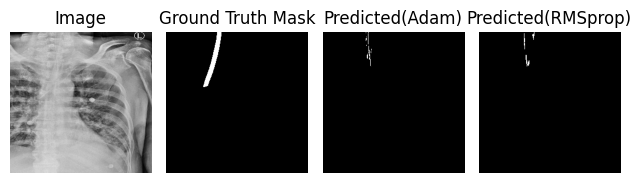

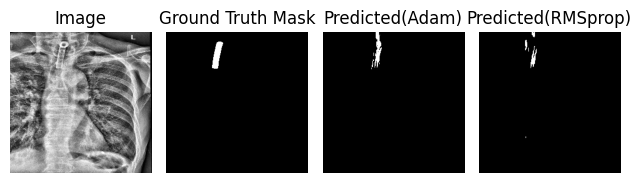

4
/content/datasets/ETT_v3/ETT_v3/Fold4
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


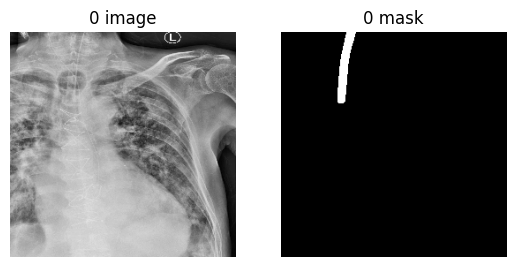

Found 285 images belonging to 1 classes.
Found 285 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9962
Epoch 1: accuracy improved from -inf to 0.99623, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_adam_unet_checkpoint.model.keras
143/143 [==============================] - 32s 224ms/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 7.3333 - val_accuracy: 0.9916 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9962
Epoch 2: accuracy improved from 0.99623 to 0.99625, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_adam_unet_checkpoint.model.keras
143/143 [==============================] - 32s 226ms/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 7.5806 - val_accuracy: 0.9918 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9964
Epoch 3: accuracy improved from 0.99625 to 0.

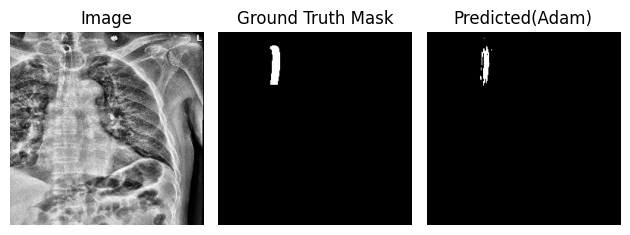

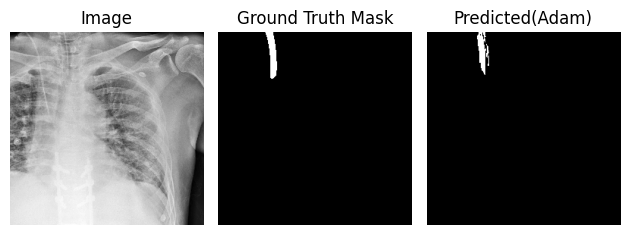

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9957
Epoch 1: accuracy improved from -inf to 0.99571, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 31s 219ms/step - loss: 0.0104 - accuracy: 0.9957 - val_loss: 4.5790 - val_accuracy: 0.9919 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9957
Epoch 2: accuracy did not improve from 0.99571
143/143 [==============================] - 29s 204ms/step - loss: 0.0110 - accuracy: 0.9957 - val_loss: 4.0658 - val_accuracy: 0.9918 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9957
Epoch 3: accuracy improved from 0.99571 to 0.99574, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 32s 222ms/step - loss: 0.0105 -

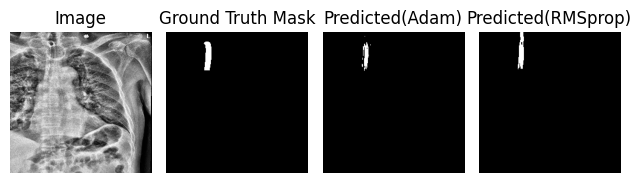

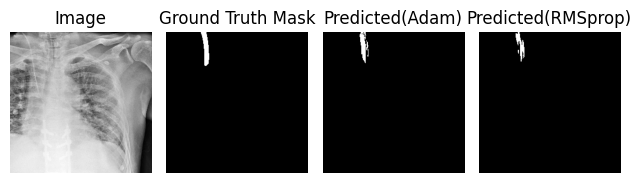

5
/content/datasets/ETT_v3/ETT_v3/Fold5
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


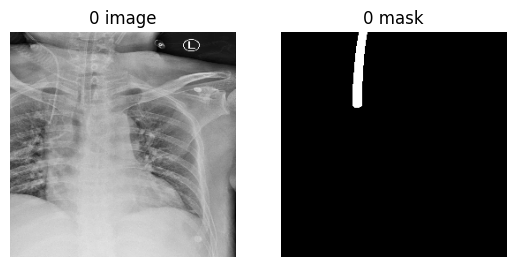

Found 285 images belonging to 1 classes.
Found 285 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9964
Epoch 1: accuracy improved from -inf to 0.99638, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_adam_unet_checkpoint.model.keras
143/143 [==============================] - 38s 265ms/step - loss: 0.0088 - accuracy: 0.9964 - val_loss: 4.0297 - val_accuracy: 0.9928 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9965
Epoch 2: accuracy improved from 0.99638 to 0.99646, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_adam_unet_checkpoint.model.keras
143/143 [==============================] - 31s 219ms/step - loss: 0.0088 - accuracy: 0.9965 - val_loss: 3.8537 - val_accuracy: 0.9928 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9965
Epoch 3: accuracy improved from 0.99646 to 0.

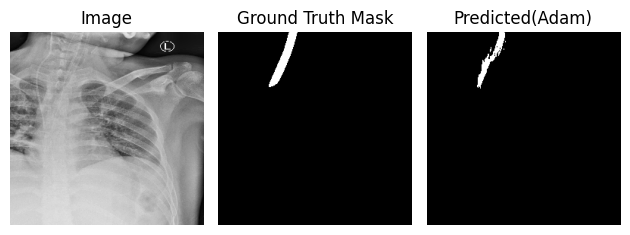

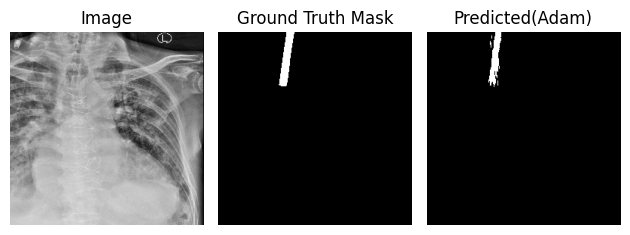

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9958
Epoch 1: accuracy improved from -inf to 0.99580, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 45s 316ms/step - loss: 0.0103 - accuracy: 0.9958 - val_loss: 3.4874 - val_accuracy: 0.9928 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9957
Epoch 2: accuracy did not improve from 0.99580
143/143 [==============================] - 29s 205ms/step - loss: 0.0108 - accuracy: 0.9957 - val_loss: 3.5134 - val_accuracy: 0.9922 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9958
Epoch 3: accuracy improved from 0.99580 to 0.99581, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_rmsprop_unet_checkpoint.model.keras
143/143 [==============================] - 31s 220ms/step - loss: 0.0102 -

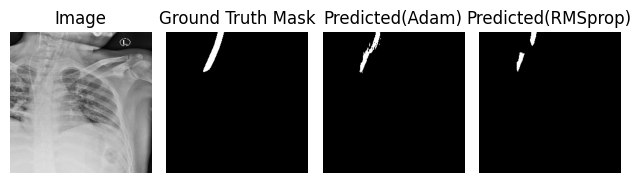

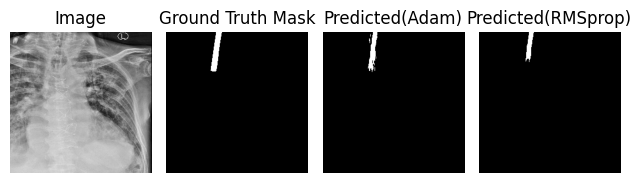

In [89]:
for fold_num in range(1, 6):
  print(fold_num)
  current_fold_path = fold_pathes[fold_num-1]
  print(current_fold_path)
  myGen = trainGenerator(2, current_fold_path, "train", "trainannot", gen_args, save_to_dir = current_fold_path + "/aug")

  checkpoint_save_path_1="/content/drive/MyDrive/ml_hw2/model_ck/f{}_adam_unet_checkpoint.model.keras".format(fold_num)
  checkpoint_save_path_2="/content/drive/MyDrive/ml_hw2/model_ck/f{}_rmsprop_unet_checkpoint.model.keras".format(fold_num)


  earlystop = EarlyStopping(monitor='loss', patience=5,
                            mode='min', verbose=1)

  checkpoint_adam = ModelCheckpoint(checkpoint_save_path_1,
                              monitor='accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  checkpoint_rmsprop = ModelCheckpoint(checkpoint_save_path_2,
                              monitor='accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  reduce_lr=ReduceLROnPlateau(monitor='accuracy',
                              patience=3,
                              verbose=1,
                              factor=0.1,
                              min_lr=0.00001
                              )

  val_images, val_masks = read_imgs_and_prepare(current_fold_path+val, current_fold_path+valannot)

  if val_images.any() and val_masks.any():
    # 檢查圖

    plt.figure()
    print("shape of 1st image", val_images[2].shape)
    print("shape of 1st mask:", val_masks[2].shape)

    plt.subplot(1, 2, 1)
    plt.imshow(val_images[2], cmap='gray')
    plt.title(f"{0} image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(val_masks[2], cmap='gray')
    plt.title(f"{0} mask")
    plt.axis('off')
    plt.show()

  perform_adam = []
  perform_rmsprop = []

  test_images, test_masks = read_imgs_and_prepare(current_fold_path+test, current_fold_path+testannot)
  train_images, train_masks = read_imgs_and_prepare(current_fold_path+train, current_fold_path+trainannot)


  unet_model_adam.fit(myGen,
            steps_per_epoch=287/2,
            epochs= 10,
            validation_data=(val_images, val_masks),
            validation_steps= (val_images.shape[0] // 2),
            callbacks=[checkpoint_adam, earlystop, reduce_lr])

  unet_model_adam.evaluate(test_images, test_masks, verbose=1, batch_size=2)
  current_results_adam_test = unet_model_adam.predict(test_images, 32, verbose=1)
  current_results_adam_train = unet_model_adam.predict(train_images, 32, verbose=1)
  perform_adam.append(get_perform(current_results_adam_train, current_results_adam_test, "adam", "Fold"+str(fold_num), train_masks, test_masks))
  print(perform_adam)
  df1 = pd.DataFrame(perform_adam, columns=columns)
  path = '/content/drive/MyDrive/output_unet.csv'
  with open(path, 'a', encoding = 'utf-8-sig') as f:
    df1.to_csv(f, header=f.tell()==0)

  for index in range(2):
    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[index], cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(current_results_adam_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(Adam)")

    fig.tight_layout()

  plt.show()

  unet_model_rmsprop.fit(myGen,
               steps_per_epoch=287/2,
               epochs= 10,
               validation_data=(val_images, val_masks),
               validation_steps= (val_images.shape[0] // 2),
               callbacks=[checkpoint_rmsprop, earlystop, reduce_lr])

  unet_model_rmsprop.evaluate(test_images, test_masks, verbose=1, batch_size=2)
  current_results_rmsprop_test = unet_model_rmsprop.predict(test_images, 32, verbose=1)
  current_results_rmsprop_train = unet_model_rmsprop.predict(train_images, 32, verbose=1)

  perform_rmsprop.append(get_perform(current_results_rmsprop_train, current_results_rmsprop_test, "rmsprop", "Fold"+str(fold_num), train_masks, test_masks))

  print(perform_rmsprop)

  df2 = pd.DataFrame(perform_rmsprop, columns=columns)
  # result_df = pd.concat([df1, df2], ignore_index=True)
  with open(path, 'a', encoding = 'utf-8-sig') as f:
    df2.to_csv(f, header=f.tell()==0)

  for index in range(2):
    fig = plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(test_images[index], cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 4, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(current_results_adam_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(Adam)")

    plt.subplot(1, 4, 4)
    plt.imshow(current_results_rmsprop_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(RMSprop)")

    fig.tight_layout()

  plt.show()

In [18]:
def unet_plus_plus(input_size = (256,256,1), base_filter_num=64 , opt ="Adam"):
    inputs = Input(input_size)
    conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv0_0)

    conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_0)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_0)

    up1_0 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_0)
    merge00_10 = concatenate([conv0_0,up1_0], axis=-1)
    conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge00_10)
    conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_1)

    conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv2_0)

    up2_0 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_0)
    merge10_20 = concatenate([conv1_0,up2_0], axis=-1)
    conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_20)
    conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)

    up1_1 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_1)
    merge01_11 = concatenate([conv0_0,conv0_1,up1_1], axis=-1)
    conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge01_11)
    conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_2)

    conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_0)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

    up3_0 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_0)
    merge20_30 = concatenate([conv2_0,up3_0], axis=-1)
    conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge20_30)
    conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)

    up2_1 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    merge11_21 = concatenate([conv1_0,conv1_1,up2_1], axis=-1)
    conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11_21)
    conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_2)

    up1_2 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_2)
    merge02_12 = concatenate([conv0_0,conv0_1,conv0_2,up1_2], axis=-1)
    conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge02_12)
    conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_3)

    conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_0)

    up4_0 = Conv2DTranspose(base_filter_num*8, (2, 2), strides=(2, 2), padding='same')(conv4_0)
    merge30_40 = concatenate([conv3_0,up4_0], axis = -1)
    conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge30_40)
    conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)

    up3_1 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    merge21_31 = concatenate([conv2_0,conv2_1,up3_1], axis = -1)
    conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge21_31)
    conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_2)

    up2_2 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_2)
    merge12_22 = concatenate([conv1_0,conv1_1,conv1_2,up2_2], axis = -1)
    conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge12_22)
    conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_3)

    up1_3 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_3)
    merge03_13 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up1_3], axis = -1)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge03_13)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_4)

    conv0_4 = Conv2D(1, 1, activation = 'sigmoid')(conv0_4)

    model = Model(inputs = inputs, outputs = conv0_4)

    if (opt == "Adam"):
      print("Adam")
      model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    elif (opt == "rmsprop"):
      print("rmsprop")
      model.compile(optimizer = RMSprop(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

	  # model.summary()
    return model

In [20]:
unetpp_model_adam = unet_plus_plus(opt = "Adam")
unetpp_model_rmsprop = unet_plus_plus(opt = "rmsprop")

Adam
rmsprop


1
/content/datasets/ETT_v3/ETT_v3/Fold1
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


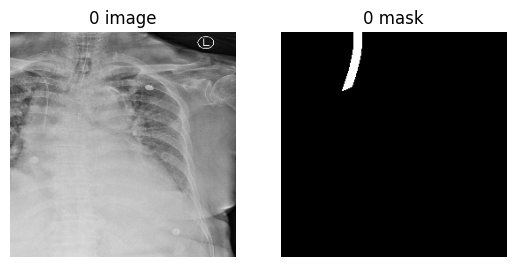

Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9831


Epoch 1: accuracy improved from -inf to 0.98308, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 91s 483ms/step - loss: 0.0714 - accuracy: 0.9831 - val_loss: 12.6112 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9901
Epoch 2: accuracy improved from 0.98308 to 0.99009, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 48s 331ms/step - loss: 0.0296 - accuracy: 0.9901 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9901
Epoch 3: accuracy improved from 0.99009 to 0.99011, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 47s 327ms/step - loss: 0.0266 - accuracy: 0.9901 - lr: 1.0000e-04
Epoch

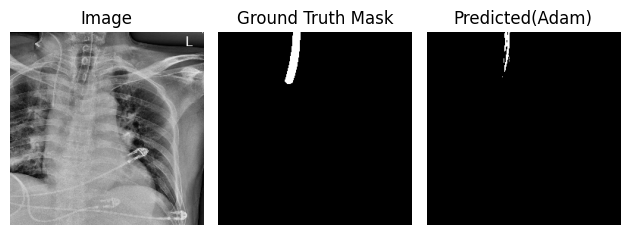

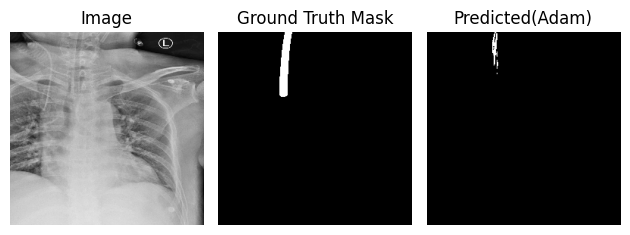

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9899


Epoch 1: accuracy improved from -inf to 0.98989, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 98s 631ms/step - loss: 0.0773 - accuracy: 0.9899 - val_loss: 13.2143 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9898
Epoch 2: accuracy did not improve from 0.98989
143/143 [==============================] - 45s 312ms/step - loss: 0.0600 - accuracy: 0.9898 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9899
Epoch 3: accuracy improved from 0.98989 to 0.98991, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f1_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 46s 319ms/step - loss: 0.0559 - accuracy: 0.9899 - lr: 1.0000e-04
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9898
E

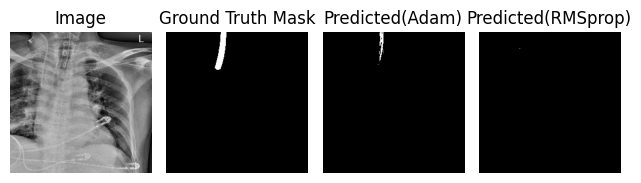

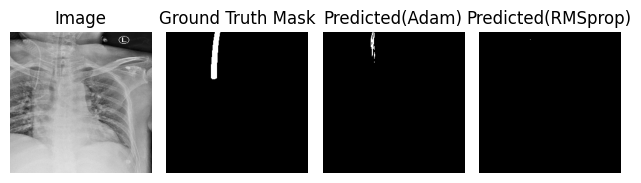

2
/content/datasets/ETT_v3/ETT_v3/Fold2
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


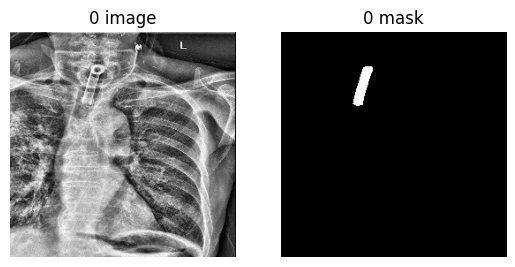

Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9940


Epoch 1: accuracy improved from -inf to 0.99398, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 56s 391ms/step - loss: 0.0154 - accuracy: 0.9940 - val_loss: 16.1087 - val_accuracy: 0.9911 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9942
Epoch 2: accuracy improved from 0.99398 to 0.99419, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 49s 343ms/step - loss: 0.0148 - accuracy: 0.9942 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9943
Epoch 3: accuracy improved from 0.99419 to 0.99431, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 47s 327ms/step - loss: 0.0145 - accuracy: 0.9943 - lr: 1.0000e-04
Epoch

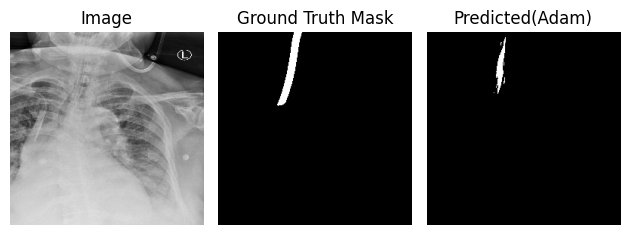

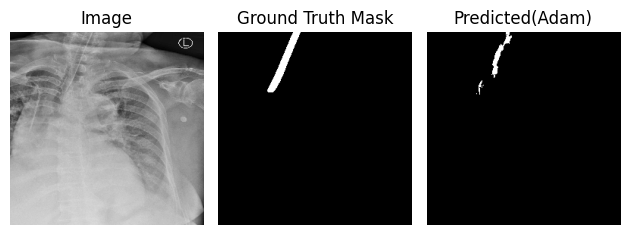

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9899


Epoch 1: accuracy improved from -inf to 0.98992, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 53s 367ms/step - loss: 0.0300 - accuracy: 0.9899 - val_loss: 5.8098 - val_accuracy: 0.9882 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9897
Epoch 2: accuracy did not improve from 0.98992
143/143 [==============================] - 44s 306ms/step - loss: 0.0292 - accuracy: 0.9897 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9901
Epoch 3: accuracy improved from 0.98992 to 0.99006, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f2_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 46s 319ms/step - loss: 0.0284 - accuracy: 0.9901 - lr: 1.0000e-05
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9902
Ep

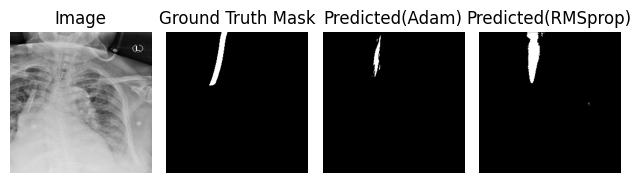

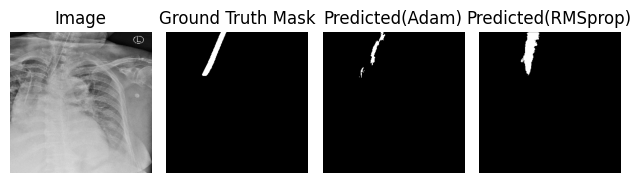

3
/content/datasets/ETT_v3/ETT_v3/Fold3
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


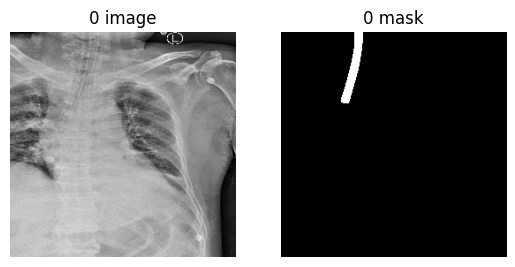

Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9954


Epoch 1: accuracy improved from -inf to 0.99542, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 60s 420ms/step - loss: 0.0115 - accuracy: 0.9954 - val_loss: 4.5732 - val_accuracy: 0.9915 - lr: 1.0000e-04
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9954
Epoch 2: accuracy did not improve from 0.99542
143/143 [==============================] - 45s 310ms/step - loss: 0.0115 - accuracy: 0.9954 - lr: 1.0000e-04
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9955
Epoch 3: accuracy improved from 0.99542 to 0.99548, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 47s 325ms/step - loss: 0.0114 - accuracy: 0.9955 - lr: 1.0000e-04
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9955
Epoch 4:

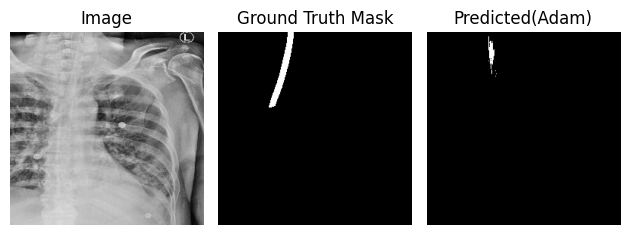

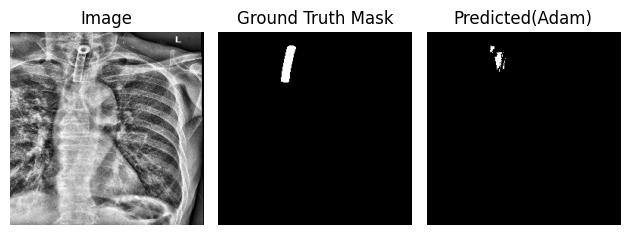

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9916


Epoch 1: accuracy improved from -inf to 0.99162, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 57s 401ms/step - loss: 0.0232 - accuracy: 0.9916 - val_loss: 6.3621 - val_accuracy: 0.9881 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9914
Epoch 2: accuracy did not improve from 0.99162
143/143 [==============================] - 45s 310ms/step - loss: 0.0233 - accuracy: 0.9914 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9917
Epoch 3: accuracy improved from 0.99162 to 0.99173, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f3_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 46s 318ms/step - loss: 0.0230 - accuracy: 0.9917 - lr: 1.0000e-05
Epoch 4/10
144/143 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9915
Ep

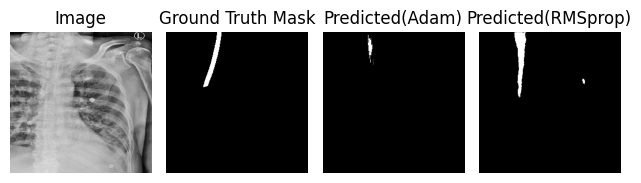

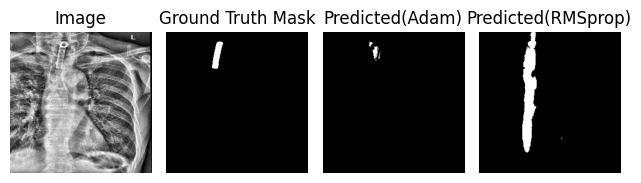

4
/content/datasets/ETT_v3/ETT_v3/Fold4
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


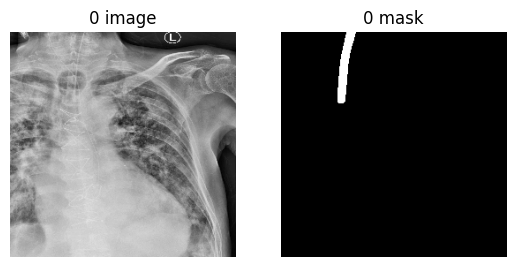

Found 285 images belonging to 1 classes.
Found 285 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9965
Epoch 1: accuracy improved from -inf to 0.99652, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 63s 441ms/step - loss: 0.0086 - accuracy: 0.9965 - val_loss: 10.6832 - val_accuracy: 0.9911 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9965
Epoch 2: accuracy improved from 0.99652 to 0.99655, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 50s 349ms/step - loss: 0.0085 - accuracy: 0.9965 - val_loss: 11.6168 - val_accuracy: 0.9910 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9966
Epoch 3: accuracy improved from 0.99655

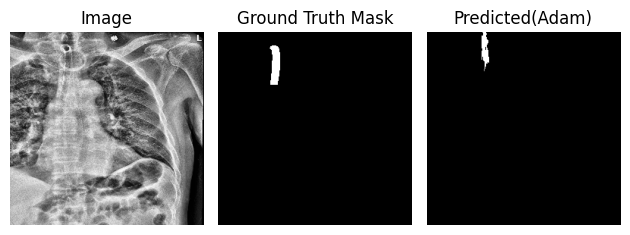

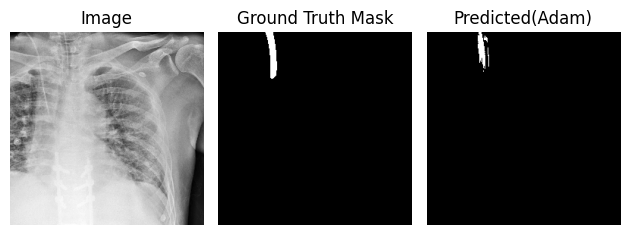

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9920
Epoch 1: accuracy improved from -inf to 0.99205, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 51s 356ms/step - loss: 0.0214 - accuracy: 0.9920 - val_loss: 5.2317 - val_accuracy: 0.9900 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9918
Epoch 2: accuracy did not improve from 0.99205
143/143 [==============================] - 47s 325ms/step - loss: 0.0214 - accuracy: 0.9918 - val_loss: 3.5557 - val_accuracy: 0.9896 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9921
Epoch 3: accuracy improved from 0.99205 to 0.99208, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f4_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 52s 360ms/step - loss: 0.02

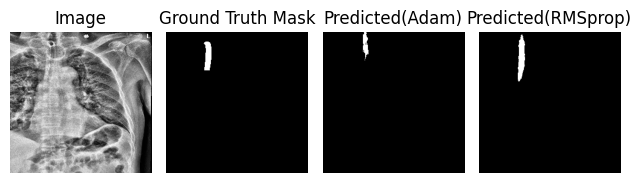

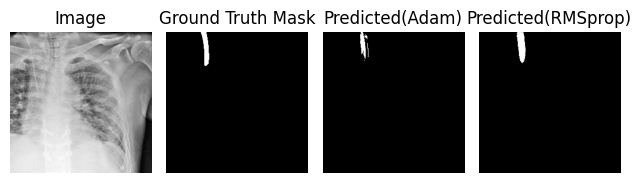

5
/content/datasets/ETT_v3/ETT_v3/Fold5
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


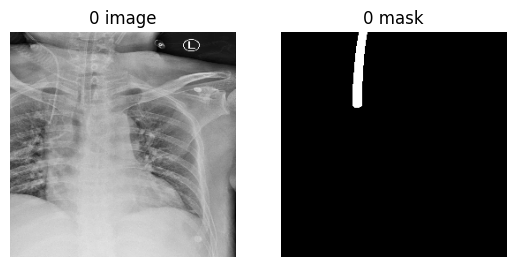

Found 285 images belonging to 1 classes.
Found 285 images belonging to 1 classes.
Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9967
Epoch 1: accuracy improved from -inf to 0.99670, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_adam_unetpp_checkpoint.model.keras
143/143 [==============================] - 56s 387ms/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 3.2490 - val_accuracy: 0.9924 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9967
Epoch 2: accuracy did not improve from 0.99670
143/143 [==============================] - 47s 327ms/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 3.2083 - val_accuracy: 0.9927 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9968
Epoch 3: accuracy improved from 0.99670 to 0.99682, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_adam_unetpp_checkpoint.model.

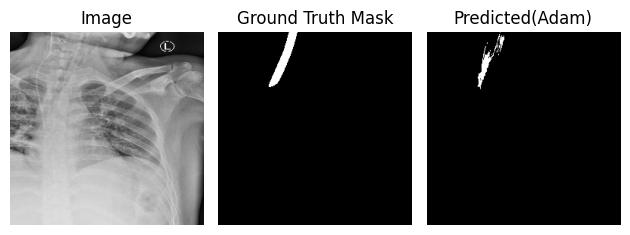

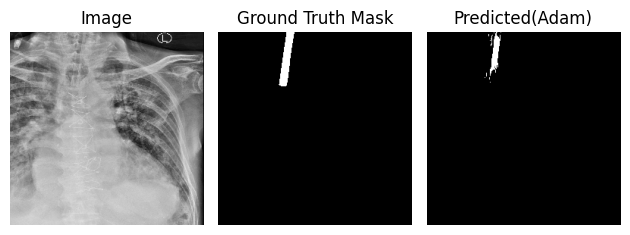

Epoch 1/10
144/143 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9923
Epoch 1: accuracy improved from -inf to 0.99226, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 49s 344ms/step - loss: 0.0198 - accuracy: 0.9923 - val_loss: 3.2361 - val_accuracy: 0.9907 - lr: 1.0000e-05
Epoch 2/10
144/143 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9923
Epoch 2: accuracy improved from 0.99226 to 0.99232, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_rmsprop_unetpp_checkpoint.model.keras
143/143 [==============================] - 48s 335ms/step - loss: 0.0197 - accuracy: 0.9923 - val_loss: 3.4307 - val_accuracy: 0.9901 - lr: 1.0000e-05
Epoch 3/10
144/143 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9925
Epoch 3: accuracy improved from 0.99232 to 0.99253, saving model to /content/drive/MyDrive/ml_hw2/model_ck/f5_rmsprop

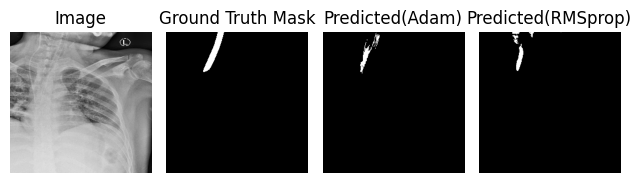

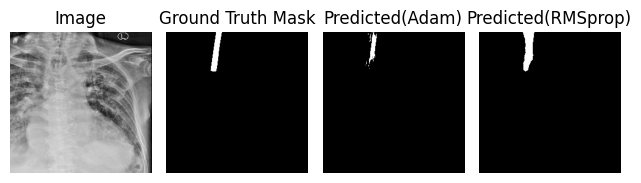

In [92]:
for fold_num in range(1, 6):
  print(fold_num)
  current_fold_path = fold_pathes[fold_num-1]
  print(current_fold_path)
  myGen = trainGenerator(2, current_fold_path, "train", "trainannot", gen_args, save_to_dir = current_fold_path + "/aug")

  checkpoint_save_path_1="/content/drive/MyDrive/ml_hw2/model_ck/f{}_adam_unetpp_checkpoint.model.keras".format(fold_num)
  checkpoint_save_path_2="/content/drive/MyDrive/ml_hw2/model_ck/f{}_rmsprop_unetpp_checkpoint.model.keras".format(fold_num)


  earlystop = EarlyStopping(monitor='loss', patience=5,
                            mode='min', verbose=1)

  checkpoint_adam = ModelCheckpoint(checkpoint_save_path_1,
                              monitor='accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  checkpoint_rmsprop = ModelCheckpoint(checkpoint_save_path_2,
                              monitor='accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  reduce_lr=ReduceLROnPlateau(monitor='accuracy',
                              patience=3,
                              verbose=1,
                              factor=0.1,
                              min_lr=0.00001
                              )

  val_images, val_masks = read_imgs_and_prepare(current_fold_path+val, current_fold_path+valannot)

  if val_images.any() and val_masks.any():
    # 檢查圖

    plt.figure()
    print("shape of 1st image", val_images[2].shape)
    print("shape of 1st mask:", val_masks[2].shape)

    plt.subplot(1, 2, 1)
    plt.imshow(val_images[2], cmap='gray')
    plt.title(f"{0} image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(val_masks[2], cmap='gray')
    plt.title(f"{0} mask")
    plt.axis('off')
    plt.show()

  perform_adam_pp = []
  perform_rmsprop_pp = []

  test_images, test_masks = read_imgs_and_prepare(current_fold_path+test, current_fold_path+testannot)
  train_images, train_masks = read_imgs_and_prepare(current_fold_path+train, current_fold_path+trainannot)

  unetpp_model_adam.fit(myGen,
            steps_per_epoch=287/2,
            epochs= 10,
            validation_data=(val_images, val_masks),
            validation_steps= (val_images.shape[0] // 2),
            callbacks=[checkpoint_adam, earlystop, reduce_lr])

  unetpp_model_adam.evaluate(test_images, test_masks, verbose=1, batch_size=2)
  current_results_adam_test = unetpp_model_adam.predict(test_images, 32, verbose=1)
  current_results_adam_train = unetpp_model_adam.predict(train_images, 32, verbose=1)

  perform_adam_pp.append(get_perform(current_results_adam_train, current_results_adam_test, "adam", "Fold"+str(fold_num), train_masks, test_masks))
  print(perform_adam_pp)
  df1 = pd.DataFrame(perform_adam_pp, columns=columns)
  path = '/content/drive/MyDrive/output_unetpp.csv'
  with open(path, 'a', encoding = 'utf-8-sig') as f:
    df1.to_csv(f, header=f.tell()==0)

  for index in range(2):
    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[index], cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(current_results_adam_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(Adam)")

    fig.tight_layout()

  plt.show()

  unetpp_model_rmsprop.fit(myGen,
               steps_per_epoch=287/2,
               epochs= 10,
               validation_data=(val_images, val_masks),
               validation_steps= (val_images.shape[0] // 2),
               callbacks=[checkpoint_rmsprop, earlystop, reduce_lr])

  unetpp_model_rmsprop.evaluate(test_images, test_masks, verbose=1, batch_size=2)
  current_results_rmsprop_test = unetpp_model_rmsprop.predict(test_images, 32, verbose=1)
  current_results_rmsprop_train = unetpp_model_rmsprop.predict(train_images, 32, verbose=1)

  perform_rmsprop_pp.append(get_perform(current_results_rmsprop_train, current_results_rmsprop_test, "rmsprop", "Fold"+str(fold_num), train_masks, test_masks))

  print(perform_rmsprop_pp)

  df2 = pd.DataFrame(perform_rmsprop_pp, columns=columns)
  # result_df = pd.concat([df1, df2], ignore_index=True)
  with open(path, 'a', encoding = 'utf-8-sig') as f:
    df2.to_csv(f, header=f.tell()==0)

  for index in range(2):
    fig = plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(test_images[index], cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 4, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(current_results_adam_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(Adam)")

    plt.subplot(1, 4, 4)
    plt.imshow(current_results_rmsprop_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(RMSprop)")

    fig.tight_layout()

  plt.show()

In [24]:
import keras.saving

1
/content/datasets/ETT_v3/ETT_v3/Fold1
shape of 1st image (256, 256, 1)
shape of 1st mask: (256, 256, 1)


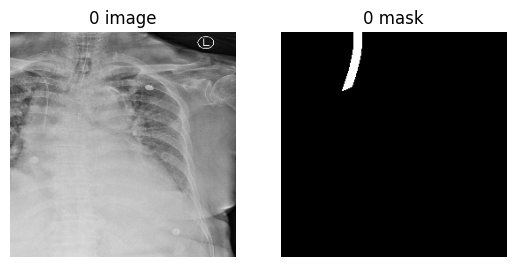

9/9 [==============================] - 11s 1s/step
--train--
Mean IOU: 0.44170687423651417
Mean mec: 3.881145954316686
Mean error_half: 7.317073170731708
Mean error_one: 17.421602787456447
--test--
Mean IOU: 0.19044915057963716
Mean mec: 2.677304964539007
Mean error_half: 19.148936170212767
Mean error_one: 25.53191489361702
[['Fold1', 'rmsprop', 0.44170687423651417, 3.881145954316686, 7.317073170731708, 17.421602787456447, 0.19044915057963716, 2.677304964539007, 19.148936170212767, 25.53191489361702]]


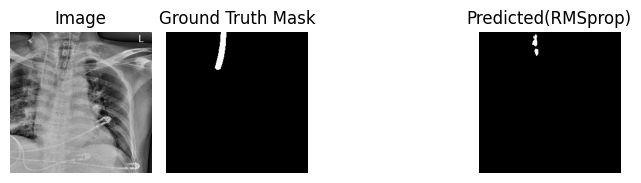

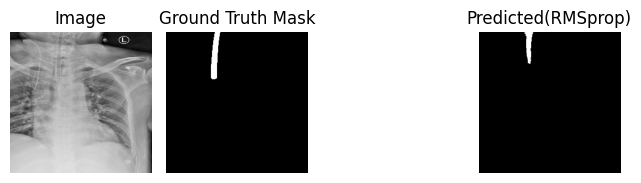

In [25]:
for fold_num in range(1, 2):
  print(fold_num)
  current_fold_path = fold_pathes[fold_num-1]
  print(current_fold_path)
  myGen = trainGenerator(2, current_fold_path, "train", "trainannot", gen_args, save_to_dir = current_fold_path + "/aug")

  checkpoint_save_path_1="/content/drive/MyDrive/ml_hw2/model_ck/f{}_adam_unetpp_checkpoint.model.keras".format(fold_num)
  checkpoint_save_path_2="/content/drive/MyDrive/ml_hw2/model_ck/f{}_rmsprop_unetpp_checkpoint.model.keras".format(fold_num)


  earlystop = EarlyStopping(monitor='loss', patience=5,
                            mode='min', verbose=1)

  checkpoint_adam = ModelCheckpoint(checkpoint_save_path_1,
                              monitor='accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  checkpoint_rmsprop = ModelCheckpoint(checkpoint_save_path_2,
                              monitor='accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  reduce_lr=ReduceLROnPlateau(monitor='accuracy',
                              patience=3,
                              verbose=1,
                              factor=0.1,
                              min_lr=0.00001
                              )

  val_images, val_masks = read_imgs_and_prepare(current_fold_path+val, current_fold_path+valannot)

  if val_images.any() and val_masks.any():
    # 檢查圖

    plt.figure()
    print("shape of 1st image", val_images[2].shape)
    print("shape of 1st mask:", val_masks[2].shape)

    plt.subplot(1, 2, 1)
    plt.imshow(val_images[2], cmap='gray')
    plt.title(f"{0} image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(val_masks[2], cmap='gray')
    plt.title(f"{0} mask")
    plt.axis('off')
    plt.show()

  perform_adam_pp = []
  perform_rmsprop_pp = []

  test_images, test_masks = read_imgs_and_prepare(current_fold_path+test, current_fold_path+testannot)
  train_images, train_masks = read_imgs_and_prepare(current_fold_path+train, current_fold_path+trainannot)

  # unetpp_model_adam.fit(myGen,
  #           steps_per_epoch=287/2,
  #           epochs= 10,
  #           validation_data=(val_images, val_masks),
  #           validation_steps= (val_images.shape[0] // 2),
  #           callbacks=[checkpoint_adam, earlystop, reduce_lr])

  # unetpp_model_adam.evaluate(test_images, test_masks, verbose=1, batch_size=2)
  # current_results_adam_test = unetpp_model_adam.predict(test_images, 32, verbose=1)
  # current_results_adam_train = unetpp_model_adam.predict(train_images, 32, verbose=1)

  # perform_adam_pp.append(get_perform(current_results_adam_train, current_results_adam_test, "adam", "Fold"+str(fold_num), train_masks, test_masks))
  # print(perform_adam_pp)
  # df1 = pd.DataFrame(perform_adam_pp, columns=columns)
  path = '/content/drive/MyDrive/output_unetpp.csv'
  # # with open(path, 'a', encoding = 'utf-8-sig') as f:
  # #   df1.to_csv(f, header=f.tell()==0)

  # for index in range(2):
  #   fig = plt.figure()
  #   plt.subplot(1, 3, 1)
  #   plt.imshow(test_images[index], cmap='gray')
  #   plt.axis('off')
  #   plt.title('Image')

  #   plt.subplot(1, 3, 2)
  #   plt.imshow(test_masks[index], cmap='gray')
  #   plt.title("Ground Truth Mask")
  #   plt.axis('off')

  #   plt.subplot(1, 3, 3)
  #   plt.imshow(current_results_adam_test[index], cmap='gray')
  #   plt.axis('off')
  #   plt.title("Predicted(Adam)")

  #   fig.tight_layout()

  # plt.show()

  # unetpp_model_rmsprop.fit(myGen,
  #              steps_per_epoch=256/2,
  #              epochs= 10,
  #              validation_data=(val_images, val_masks),
  #              validation_steps= (val_images.shape[0] // 2),
  #              callbacks=[checkpoint_rmsprop, earlystop, reduce_lr])

  unetpp_model_rmsprop = keras.saving.load_model("/content/drive/MyDrive/ml_hw2/model_ck/f4_rmsprop_unetpp_checkpoint.model.keras")

  unetpp_model_rmsprop.evaluate(test_images, test_masks, verbose=1, batch_size=2)
  current_results_rmsprop_test = unetpp_model_rmsprop.predict(test_images, 32, verbose=1)
  current_results_rmsprop_train = unetpp_model_rmsprop.predict(train_images, 32, verbose=1)

  perform_rmsprop_pp.append(get_perform(current_results_rmsprop_train, current_results_rmsprop_test, "rmsprop", "Fold"+str(fold_num), train_masks, test_masks))

  print(perform_rmsprop_pp)

  df2 = pd.DataFrame(perform_rmsprop_pp, columns=columns)
  result_df = pd.concat([df1, df2], ignore_index=True)
  # with open(path, 'a', encoding = 'utf-8-sig') as f:
  #   df2.to_csv(f, header=f.tell()==0)

  for index in range(2):
    fig = plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(test_images[index], cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 4, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(current_results_adam_test[index], cmap='gray')
    # plt.axis('off')
    # plt.title("Predicted(Adam)")

    plt.subplot(1, 4, 4)
    plt.imshow(current_results_rmsprop_test[index], cmap='gray')
    plt.axis('off')
    plt.title("Predicted(RMSprop)")

    fig.tight_layout()

  plt.show()